In [64]:
from model_deployment.mine_goal_terms import GoalTermDB, GoalTermRecord
from tactic_gen.proof_distance import levenshtein_dist_fast
from tactic_gen.step_parser import norm 
from model_deployment.goal_term import term_dist

import matplotlib.pyplot as plt

In [65]:
GOAL_DB_LOC = "/home/ubuntu/coq-modeling/proof-db"

In [66]:
goal_term_db = GoalTermDB.load_dist(GOAL_DB_LOC)

In [67]:
goal_sample = goal_term_db.sample(100)

In [68]:
def norm_proof(steps: list[str]) -> list[str]:
    return [norm(s) for s in steps]

In [69]:
points: list[tuple[int, int]] = []
for i in range(len(goal_sample)):
    for j in range(i + 1, len(goal_sample)):
        lev_dist = levenshtein_dist_fast(norm_proof(goal_sample[i].proof), norm_proof(goal_sample[j].proof))
        goal_term_dist = term_dist(goal_sample[i].term, goal_sample[j].term)
        points.append((lev_dist, goal_term_dist))

Text(0, 0.5, 'Edit Distance Between Goals')

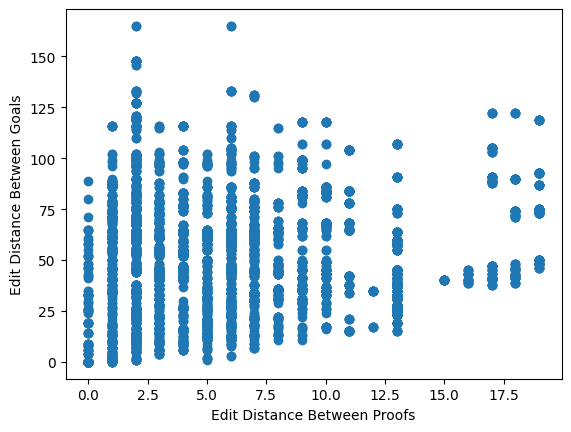

In [70]:
fig, ax = plt.subplots()
xs = [x for x, y in points]
ys = [y for x, y in points]
ax.scatter(xs, ys)
ax.set_xlabel("Edit Distance Between Proofs")
ax.set_ylabel("Edit Distance Between Goals")

In [71]:
import numpy as np
np.corrcoef(np.array(xs), np.array(ys))

array([[1.        , 0.15090247],
       [0.15090247, 1.        ]])

In [72]:
pairs: list[tuple[GoalTermRecord, GoalTermRecord]] = []
for i in range(len(goal_sample)):
    for j in range(i + 1, len(goal_sample)):
        pairs.append((goal_sample[i], goal_sample[j]))

In [73]:
def term_over_proof(pair: tuple[GoalTermRecord, GoalTermRecord]) -> float:
    r1, r2 = pair
    proof_dist = levenshtein_dist_fast(norm_proof(r1.proof), norm_proof(r2.proof))
    goal_dist = term_dist(r1.term, r2.term)
    if proof_dist == 0:
        proof_dist = 1e-5
    return goal_dist / proof_dist

def proof_over_term(pair: tuple[GoalTermRecord, GoalTermRecord]) -> float:
    r1, r2 = pair
    proof_dist = levenshtein_dist_fast(norm_proof(r1.proof), norm_proof(r2.proof))
    goal_dist = term_dist(r1.term, r2.term)
    if goal_dist == 0:
        goal_dist = 1e-5
    return proof_dist / goal_dist

In [84]:
def show_pair(p: tuple[GoalTermRecord, GoalTermRecord]) -> None:
    r1, r2 = p
    proof_dist = levenshtein_dist_fast(norm_proof(r1.proof), norm_proof(r2.proof))
    goal_dist = term_dist(r1.term, r2.term)
    print(f"Proof Dist: {proof_dist}; Goal Term Dist: {goal_dist}")
    print("Proof1: ", "".join(r1.proof))
    print("Proof2: ", "".join(r2.proof))
    print("\nGoal1:\n", r1.pretty_goal)
    print("\nGoal2:\n", r2.pretty_goal)

In [92]:
small_proofs_large_terms = list(reversed(sorted(pairs, key=term_over_proof)))

In [106]:
show_pair(small_proofs_large_terms[0])

Proof Dist: 0; Goal Term Dist: 89
Proof1:   assumption.
Proof2:   assumption.

Goal1:
 a, b, c: Prop
H: a -> b
H0: ~ (a -> b)
H1: c

a -> b

Goal2:
 x, y, y', z, n: nat
H1: x + y' + z <= n
H2: y <= y'

x + y' + z <= n


In [94]:
small_terms_large_proofs = list(reversed(sorted(pairs, key=proof_over_term)))

In [114]:
show_pair(small_terms_large_proofs[7])

Proof Dist: 5; Goal Term Dist: 2
Proof1:   assumption.
Proof2:  
    apply le_trans with (x' + y). 
    - apply (add_le_mono_r (S x) x' y). assumption.
    - assumption.

Goal1:
 x, x', y, n: nat
H1: x' + y <= S n
H2: S x <= x'

x' + y <= S n

Goal2:
 x, x', y, n: nat
H1: x' + y <= S n
H2: S x <= x'

S (x + y) <= S n


In [103]:
len(pairs)

4950

In [78]:
print()